In [1]:
import glob
import os
import pprint
from typing import List, Tuple

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor

import time

from concurrent import futures
import multiprocessing


from lib.adjustment import Adjustment
from lib.msxcolor import MSXColor
import lib.color_transform as ct

%matplotlib widget

In [2]:
image_folder = "../../resources/test_images"
image_paths = sorted(glob.glob(os.path.join(image_folder, "image*.png")))
image_paths

['../../resources/test_images/image01.png',
 '../../resources/test_images/image02.png',
 '../../resources/test_images/image03.png',
 '../../resources/test_images/image04.png',
 '../../resources/test_images/image05.png',
 '../../resources/test_images/image06.png',
 '../../resources/test_images/image07.png',
 '../../resources/test_images/image08.png',
 '../../resources/test_images/image09.png',
 '../../resources/test_images/image10.png',
 '../../resources/test_images/image11.png']

In [3]:
images = [cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB) for image_path in image_paths]
images = [cv.resize(image, (256, 192), cv.INTER_LINEAR) for image in images]

## Flowchart for converting an RGB image to sc2 image


- adjust brightness / contrast              <- rgb image
- segment image with k-means                <- rgb image
- map to msx palette, create image_idx      <- rgb image
- interlace                                 <- idx image
- vdpconvert                                <- idx image

## k-means

In [4]:
def segmentation_kmeans(image, k, niter):
    image_2D = image.reshape((-1,3))
    image_2D = np.float32(image_2D)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    attempts = niter
    ret, label, center = cv.kmeans(image_2D, k, None, criteria, attempts, cv.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    image_idx = label.reshape((image.shape[0], image.shape[1]))
    palette = center
    image_rgb = res.reshape((image.shape))
    assert image_idx.shape[0] == image_rgb.shape[0]
    return image_rgb, image_idx, palette

In [5]:
def interlace(image1, image2):
    if image1.ndim == 2:
        dst = image1.copy()
        dst[::2,:] = image2[::2,:]
    else:
        dst = image1.copy()
        dst[::2,:, :] = image2[::2,:, :]
    return dst

In [6]:
def batch_ranges_with_size(N:int, batch_size:int) -> List[Tuple[int, int]]:
    """
    Computes batch ranges with given batch size and returns a list of tuples with start and end indices.
    Parameters
    ----------
    N: int
        Total amount of samples
    batch_size: int
        Batch size, e.g. 64 samples per batch
    Returns
    -------
    List[Tuple[int, int]]
        List of tuples with start and end indices, e.g. [(start0, end0), (start1, end1),...,]
    """
    rng = []
    if N <= batch_size:
        rng.append((0, N))
    else:
        n_batches = N // batch_size
        for i in range(n_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            rng.append((start, end))
        if batch_size * n_batches < N:
            start = batch_size * n_batches
            end = N
            rng.append((start, end))
    return rng


def create_distmap(palette):
    dmap = np.zeros(shape=(16, 16))
    for i in range(16):
        dist = np.sum(np.square(np.subtract(palette[i], palette)), axis=1)
        dmap[i,:] = dist
    return dmap

def vdpconvert_tile(tile, dmap):
    dmin = 1e6
    pmin = np.array([[0, 0, 0, 0, 0, 0, 0, 0]], dtype=np.uint8)    
    for idx0 in range(1, 16):
        for idx1 in range(idx0, 16):
            p = np.zeros(shape=(1, 8)).astype(np.uint8)
            m = 0
            for x in range(8):
                i = tile[0, x]
                err0 = dmap[i, idx0]
                err1 = dmap[i, idx1]
                if err0 < err1:
                    p[0, x] = idx0
                    m += err0
                else:
                    p[0, x] = idx1
                    m += err1               
            if m<dmin:
                pmin = p
                dmin = m
    new_tile = pmin
    return new_tile


def vdpconvert_tile2(tile, dmap):
    dmin = 1e6
    pmin = np.array([[0, 0, 0, 0, 0, 0, 0, 0]], dtype=np.uint8)
    ones = np.ones(shape=(1, 8), dtype=np.uint8)
    for idx0 in range(1, 16):
        for idx1 in range(idx0, 16):
            p = np.zeros(shape=(1, 8)).astype(np.uint8)
            m = 0
            err0 = dmap[tile, idx0]
            for x in range(8):
                i = tile[0, x]
                err0 = dmap[i, idx0]
                err1 = dmap[i, idx1]
                if err0 < err1:
                    p[0, x] = idx0
                    m += err0
                else:
                    p[0, x] = idx1
                    m += err1               
            if m<dmin:
                pmin = p
                dmin = m
    new_tile = pmin
    return new_tile


def vdpconvert(image_idx, palette=None, dmap=None):
    if dmap is None:
        dmap = create_distmap(palette)
    if palette is None and dmap is None:
        raise RuntimeError(f"palette and dmap cannot both be None.")
    new_image_idx = np.zeros_like(image_idx)
    for y in range(0, image_idx.shape[0]):
        for x in range(0, image.shape[1], 8):
            tile = image_idx[y:y+1, x:x+8]
            new_tile = vdpconvert_tile(tile, dmap)
            new_image_idx[y:y+1, x:x+8] = new_tile
    return new_image_idx

def vdpconvert_mp_worker(image_idx, palette, dmap, batch):
    image_idx = vdpconvert(image_idx, palette, dmap)
    return {"image_idx": image_idx,
            "batch": batch}


def vdpconvert_mp(image_idx, palette, n_workers):
    res_list = []
    dmap = create_distmap(palette)
    batches = batch_ranges_with_size(192, 192//n_workers)
    with ProcessPoolExecutor(max_workers=n_workers, mp_context=multiprocessing.get_context('fork')) as executor:
        task_list = []
        for batch in batches:
            image_idx_batch = image_idx[batch[0]:batch[1]]
            task = executor.submit(vdpconvert_mp_worker, image_idx_batch, None, dmap, batch)
            task_list.append(task)
        for task in futures.as_completed(task_list):
            res_list.append(task.result())
    new_image_idx = np.zeros_like(image_idx)
    for res in res_list:
        new_image_idx[res["batch"][0]:res["batch"][1],:] = res["image_idx"]
    return new_image_idx

In [11]:
def style_interlaced(image, params):
    chrono = {}
    
    msxcolor = MSXColor()
    
    tic = time.time()  
    idt = params.get("interlace_delta", 50)
    ido = params.get("interlace_delta_offset", 0)
    
    if params.get("brightness", 0) > 0:
        image = Adjustment.brightness(image, params.get("brightness", 0))
    image_light = Adjustment.brightness(image, idt-ido)
    image_dark = Adjustment.brightness(image, -idt-ido)
    image_light = Adjustment.contrast_scurve(image_light, params.get("contrast"))
    image_dark = Adjustment.contrast_scurve(image_dark, params.get("contrast"))
#     image_light = Adjustment.brightness(image, params.get("interlace_delta", 50) - params.get("interlace_delta_offset", 0))
#     image_dark = Adjustment.brightness(image, -params.get("interlace_delta", 50) - params.get("interlace_delta_offset", 0))
    
#     image_light = Adjustment.contrast_scurve(image_light, params.get("contrast", 0))
#     image_dark = Adjustment.contrast_scurve(image_dark, params.get("contrast", 0))
    
    toc = time.time()
    chrono["adjustments"] = toc - tic
    
    tic = time.time()
    image_seg1, image_seg1_idx, seg1_palette = segmentation_kmeans(image_light, params["k"], 10)
    image_seg2, image_seg2_idx, seg2_palette = segmentation_kmeans(image_dark, params["k"], 10)
    toc = time.time()
    chrono["segmentation"] = toc - tic
    
    tic = time.time()
    image_msx1, image_msx1_idx, image_msx1_palette = msxcolor.cvt_color_by_idx(image_seg1_idx, seg1_palette, params)
    image_msx2, image_msx2_idx, image_msx2_palette = msxcolor.cvt_color_by_idx(image_seg2_idx, seg2_palette, params)
    # image_msx1, image_msx1_idx = msxcolor.cvt_color(image_seg1, params, with_index=True)
    # image_msx2, image_msx2_idx = msxcolor.cvt_color(image_seg2, params, with_index=True)
    
    plt.figure()
    plt.imshow(image_msx1)
    plt.show()
#     print(image_msx1_idx[128:136, 92:98])
#     print(image_msx1_idx_[128:136, 92:98])
    
#     print(image_msx1_idx.shape, image_msx1_idx_.shape)
    
#     print(image_msx2_idx[:5, :5])
#     print(image_msx2_idx_[:5, :5])

    
    toc = time.time()
    chrono["cvtcolor"] = toc - tic

    tic = time.time()
    image_interlace_idx = interlace(image_msx1_idx, image_msx2_idx)
    toc = time.time()
    chrono["interlace"] = toc - tic

    tic = time.time()
    palette = msxcolor.get_palette(params)
    image_vdp_idx = image_interlace_idx
    n_workers = params.get("n_workers")
    if n_workers is not None and n_workers > 1:
        image_vdp_idx = vdpconvert_mp(image_vdp_idx, palette, n_workers=n_workers)
    else:
        image_vdp_idx = vdpconvert(image_vdp_idx, palette)
    image_vdp_rgb = msxcolor.palette_msx1_rgbi[image_vdp_idx]
    toc = time.time()
    chrono["vdpconvert"] = toc - tic

    # msg = []
    # for k, v in chrono.items():
    #     msg.append(f"{chrono[k]}: {chrono[v]:0.3f}s")
    # print(", ".join(msg))
    pprint.pprint(chrono)
    return image_vdp_rgb


Old values:
```
center (8, 3)
label (49152, 1)
center (8, 3)
label (49152, 1)
{'adjustments': 0.008800029754638672,
 'cvtcolor': 1.5345430374145508,
 'interlace': 8.988380432128906e-05,
 'segmentation': 0.24533605575561523,
 'vdpconvert': 1.5462381839752197}
CPU times: user 2.69 s, sys: 139 ms, total: 2.83 s
Wall time: 3.39 s
```

[[128 118 241]
 [255 255 255]
 [ 89  85 224]
 [  1   1   1]
 [ 89  85 224]
 [255 255 255]
 [204 204 204]
 [ 89  85 224]]
[[ 0.52941176 -0.03529412  0.4745098 ]
 [ 1.          0.00392157  0.00392157]
 [ 0.4        -0.06666667  0.54509804]
 [ 0.00392157  0.00392157  0.00392157]
 [ 0.4        -0.06666667  0.54509804]
 [ 1.          0.00392157  0.00392157]
 [ 0.8         0.00392157  0.00392157]
 [ 0.4        -0.06666667  0.54509804]]
[[  1   1   1]
 [101 219 239]
 [ 89  85 224]
 [ 89  85 224]
 [204 204 204]
 [204 204 204]
 [  1   1   1]
 [128 118 241]]
[[ 0.00392157  0.00392157  0.00392157]
 [ 0.72941176 -0.4745098   0.23921569]
 [ 0.4        -0.06666667  0.54509804]
 [ 0.4        -0.06666667  0.54509804]
 [ 0.8         0.00392157  0.00392157]
 [ 0.8         0.00392157  0.00392157]
 [ 0.00392157  0.00392157  0.00392157]
 [ 0.52941176 -0.03529412  0.4745098 ]]
{'adjustments': 0.009551048278808594,
 'cvtcolor': 0.004567861557006836,
 'interlace': 5.698204040527344e-05,
 'segmentation': 0.249

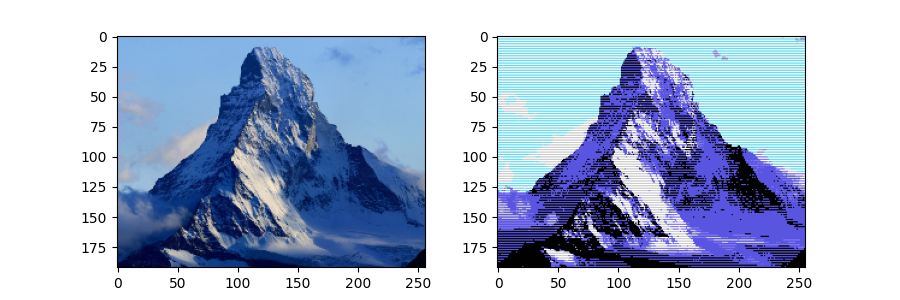

In [16]:
%%time

image = images[0]

params = {
    "colorspace": "ycrcb",
    "contrast": 50,
    "brightness": 5,
    "style": "interlace",
    "interlace_delta": 50,
    "interlace_delta_offset": 0,
    "k": 8,
    "n_workers": 4
}

image_sc2 = style_interlaced(image, params)
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].imshow(image)
axs[1].imshow(image_sc2)

center (8, 3)
label (49152, 1)
center (8, 3)
label (49152, 1)
{'adjustments': 0.007582902908325195,
 'cvtcolor': 1.635676383972168,
 'interlace': 9.775161743164062e-05,
 'segmentation': 0.26028013229370117,
 'vdpconvert': 1.787912130355835}


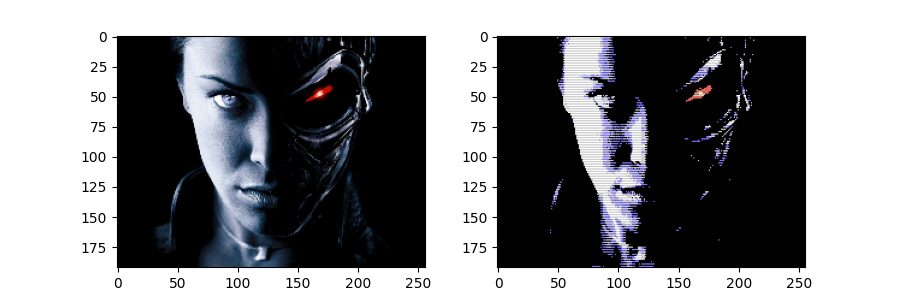

In [153]:
image = images[5]

params = {
    "colorspace": "ycrcb",
    "contrast": 30,
    "style": "interlace",
    "interlace_delta": 50,
    "interlace_delta_offset": -10,
    "k": 8,
    "n_workers": 4
}

image_sc2 = style_interlaced(image, params)
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].imshow(image)
axs[1].imshow(image_sc2)

center (8, 3)
label (49152, 1)
center (8, 3)
label (49152, 1)
{'adjustments': 0.012027978897094727,
 'cvtcolor': 1.8625972270965576,
 'interlace': 0.00011277198791503906,
 'segmentation': 0.2670869827270508,
 'vdpconvert': 5.5258629322052}


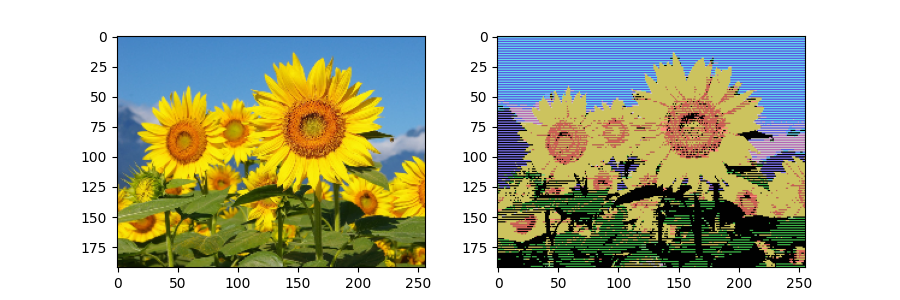

In [67]:
image = images[1]

params = {
    "colorspace": "lab",
    "contrast": 50,
    "style": "interlace",
    "interlace_delta": 50,
    "interlace_delta_offset": 10,
    "k": 8,
}

image_sc2 = style_interlaced(image, params)
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].imshow(image)
axs[1].imshow(image_sc2)

center (8, 3)
label (49152, 1)
center (8, 3)
label (49152, 1)
{'adjustments': 0.008750200271606445,
 'cvtcolor': 1.8327090740203857,
 'interlace': 7.915496826171875e-05,
 'segmentation': 0.23272299766540527,
 'vdpconvert': 5.6223249435424805}


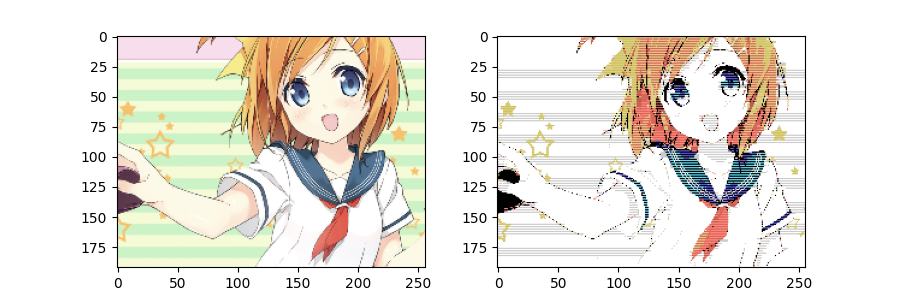

In [65]:
image = images[4]

params = {
    "colorspace": "ycrcb",
    "contrast": 50,
    "style": "interlace",
    "interlace_delta": 50,
    "interlace_delta_offset": 0,
    "k": 8,
}

image_sc2 = style_interlaced(image, params)
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].imshow(image)
axs[1].imshow(image_sc2)

center (8, 3)
label (49152, 1)
center (8, 3)
label (49152, 1)
{'adjustments': 0.008610010147094727,
 'cvtcolor': 1.5450060367584229,
 'interlace': 8.392333984375e-05,
 'segmentation': 0.2607421875,
 'vdpconvert': 5.302329063415527}


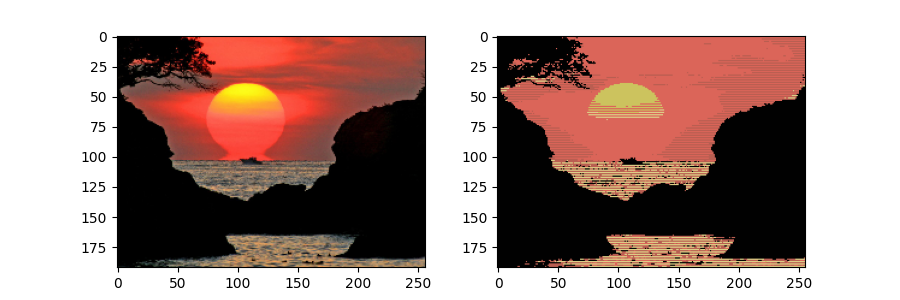

In [128]:
image = images[6]

params = {
    "colorspace": "hsv",
    "contrast": 50,
    "style": "interlace",
    "interlace_delta": 50,
    "interlace_delta_offset": 0,
    "k": 8,
}

image_sc2 = style_interlaced(image, params)
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].imshow(image)
axs[1].imshow(image_sc2)

center (8, 3)
label (49152, 1)
center (8, 3)
label (49152, 1)
{'adjustments': 0.008312225341796875,
 'cvtcolor': 1.6797449588775635,
 'interlace': 0.0001049041748046875,
 'segmentation': 0.24518394470214844,
 'vdpconvert': 1.564328908920288}
CPU times: user 2.82 s, sys: 118 ms, total: 2.94 s
Wall time: 3.55 s


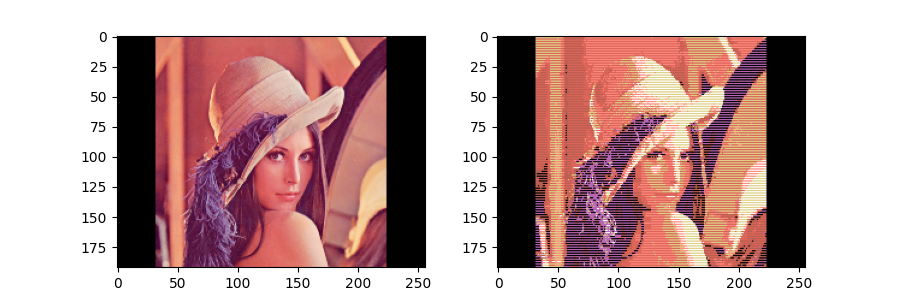

In [127]:
%%time

image = images[7]

params = {
    "colorspace": "ycrcb",
    "contrast": 30,
    "style": "interlace",
    "interlace_delta": 50,
    "interlace_delta_offset": -10,
    "k": 8,
    "n_workers": 4
}

image_sc2 = style_interlaced(image, params)
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].imshow(image)
axs[1].imshow(image_sc2)

center (8, 3)
label (49152, 1)
center (8, 3)
label (49152, 1)
{'adjustments': 0.00960397720336914,
 'cvtcolor': 1.5726871490478516,
 'interlace': 8.869171142578125e-05,
 'segmentation': 0.23284578323364258,
 'vdpconvert': 1.5639221668243408}
CPU times: user 2.67 s, sys: 106 ms, total: 2.78 s
Wall time: 3.43 s


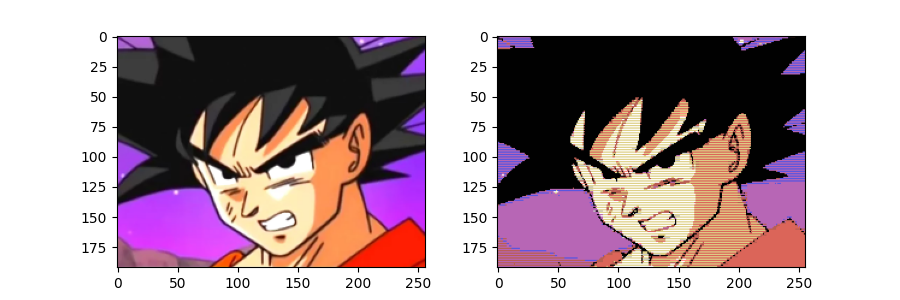

In [108]:
%%time

image = images[8]

params = {
    "colorspace": "ycrcb",
    "contrast": 10,
    "style": "interlace",
    "interlace_delta": 50,
    "interlace_delta_offset": -10,
    "k": 8,
    "n_workers": 4
}

image_sc2 = style_interlaced(image, params)
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].imshow(image)
axs[1].imshow(image_sc2)

center (8, 3)
label (49152, 1)
center (8, 3)
label (49152, 1)
{'adjustments': 0.009093761444091797,
 'cvtcolor': 2.3575141429901123,
 'interlace': 0.0003418922424316406,
 'segmentation': 0.227586030960083,
 'vdpconvert': 2.8952560424804688}
CPU times: user 3.29 s, sys: 164 ms, total: 3.45 s
Wall time: 5.55 s


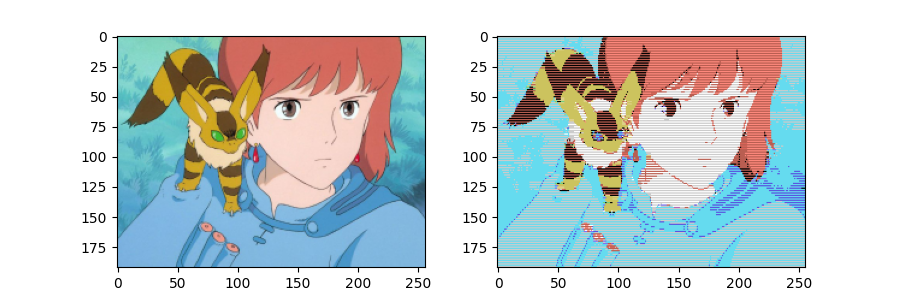

In [151]:
%%time

image = images[1]

params = {
    "colorspace": "ycrcb",
    "contrast": 10,
    "brightness": 0,
    "style": "interlace",
    "interlace_delta": 50,
    "interlace_delta_offset": -12,
    "k": 8,
    "n_workers": 4
}

image_sc2 = style_interlaced(image, params)
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].imshow(image)
axs[1].imshow(image_sc2)

center (8, 3)
label (49152, 1)
center (8, 3)
label (49152, 1)
{'adjustments': 0.010421991348266602,
 'cvtcolor': 1.5753178596496582,
 'interlace': 0.00011205673217773438,
 'segmentation': 0.1998138427734375,
 'vdpconvert': 1.6569852828979492}
CPU times: user 2.53 s, sys: 108 ms, total: 2.63 s
Wall time: 3.5 s


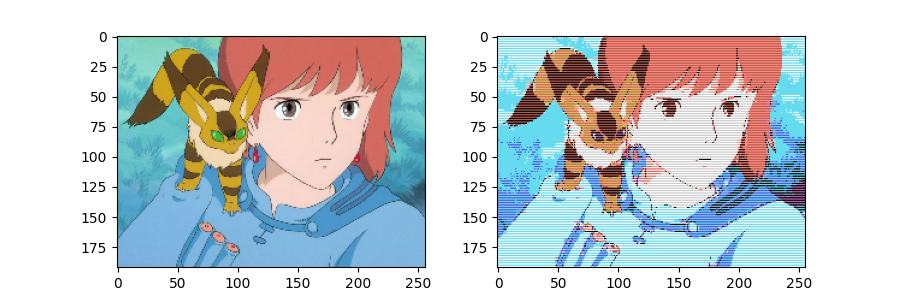

In [150]:
%%time

image = images[2]

params = {
    "colorspace": "lab",
    "contrast": 50,
    "brightness": 0,
    "style": "interlace",
    "interlace_delta": 50,
    "interlace_delta_offset": 10,
    "k": 8,
    "n_workers": 4
}

image_sc2 = style_interlaced(image, params)
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].imshow(image)
axs[1].imshow(image_sc2)

In [73]:
dmap = np.random.rand(16, 8)
dmap

array([[0.66534349, 0.10405004, 0.9676528 , 0.21656135, 0.51336342,
        0.04636274, 0.42033379, 0.91115607],
       [0.23402602, 0.18752338, 0.23744714, 0.73888234, 0.71378496,
        0.80311574, 0.84421844, 0.93692684],
       [0.64671554, 0.48126665, 0.03152908, 0.51796595, 0.42246062,
        0.32029086, 0.60922156, 0.76141237],
       [0.74128616, 0.19727259, 0.33801339, 0.00509058, 0.60135336,
        0.24630635, 0.95623389, 0.79805347],
       [0.49761631, 0.29113544, 0.82454375, 0.05172528, 0.87779922,
        0.42468767, 0.66984054, 0.18656275],
       [0.83913638, 0.46915624, 0.83788517, 0.81090754, 0.74635899,
        0.47170716, 0.32525616, 0.83639048],
       [0.67653311, 0.71601254, 0.74121413, 0.61896942, 0.47534289,
        0.62533311, 0.55403075, 0.58343529],
       [0.43195288, 0.42652818, 0.86934552, 0.05819108, 0.41007218,
        0.53540419, 0.65986975, 0.47083116],
       [0.35793283, 0.71025198, 0.22012182, 0.1235473 , 0.19264677,
        0.29934723, 0.521306

In [24]:
tile = np.array([0, 2, 3, 1, 2, 2, 0, 0], dtype=np.uint8).reshape(1, 8)
tile

array([[0, 2, 3, 1, 2, 2, 0, 0]], dtype=uint8)

In [38]:
c0 = 1
c1 = 2
vc = np.array([[c0],[c1]], dtype=np.uint8)
idx01 = vc*np.ones(shape=(1,8), dtype=np.uint8)
idx01

array([[1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2]], dtype=uint8)

In [44]:
vc[np.argmin(dmap[tile, idx01], axis=0)].T
np.sum(np.min(dmap[tile, idx01]

array([[2, 2, 1, 2, 2, 2, 2, 2]], dtype=uint8)

In [43]:
dmap[tile, idx01]

array([[0.52951612, 0.76049038, 0.4183479 , 0.59876894, 0.76049038,
        0.76049038, 0.52951612, 0.52951612],
       [0.0578728 , 0.22252317, 0.76260256, 0.22083142, 0.22252317,
        0.22252317, 0.0578728 , 0.0578728 ]])

In [45]:
dmap_c_c0c1 = dmap[tile, idx01]

In [65]:
c0c1 = np.zeros(shape=(2, 15*14//2), dtype=np.uint8)
k = 0
for i in range(1, 16):
    for j in range(i+1, 16):
        c0c1[:, k:k+1] = np.array([[i], [j]], np.uint8)
        k += 1
c0c1

array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
         8,  8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11,
        11, 11, 11, 12, 12, 12, 13, 13, 14],
       [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  3,  4,
         5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  4,  5,  6,  7,  8,
         9, 10, 11, 12, 13, 14, 15,  5,  6,  7,  8,  9, 10, 11, 12, 13,
        14, 15,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  7,  8,  9, 10,
        11, 12, 13, 14, 15,  8,  9, 10, 11, 12, 13, 14, 15,  9, 10, 11,
        12, 13, 14, 15, 10, 11, 12, 13, 14, 15, 11, 12, 13, 14, 15, 12,
        13, 14, 15, 13, 14, 15, 14, 15, 15]], dtype=uint8)

In [58]:
15*14//2

105

In [70]:
A = np.zeros(shape=(16, 16), dtype=np.uint8)

In [71]:
A[c0c1[0],c0c1[1]] = 1
A

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [72]:
dmap

array([[0.92435845, 0.52951612, 0.0578728 , 0.12214182],
       [0.81211151, 0.59876894, 0.22083142, 0.0805138 ],
       [0.55152205, 0.76049038, 0.22252317, 0.41041973],
       [0.82395868, 0.4183479 , 0.76260256, 0.30470685]])